---
title: "dynamic time warping"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

There are beautiful explanations our there of how the Dynamic Time Warping 
algorithm works. An excellent source is [this tutorial](https://www.theaidream.com/post/dynamic-time-warping-dtw-algorithm-in-time-series){target="_blank"}.

::: {.column-margin}
I also used as sources for this lecture the following pages:

* [Abhishek Mishra's Medium page](https://medium.com/walmartglobaltech/time-series-similarity-using-dynamic-time-warping-explained-9d09119e48ec){target="_blank"}

* [Romain Tavenard's DTW tutorial](https://rtavenar.github.io/blog/dtw.html){target="_blank"}

:::

In [2]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import matplotlib.gridspec as gridspec


In [3]:
#| code-summary: "define functions for calculating DTW"

def fill_dtw_cost_matrix(abs_diff):
    N1, N2 = abs_diff.shape
    cost_matrix = abs_diff.copy()  # make a copy
    # prepend row full of nan
    cost_matrix = np.vstack([np.full(N1, np.nan), cost_matrix])
    # prepend col full of nan
    cost_matrix = np.hstack([np.full((N2+1,1), np.nan), cost_matrix])
    # make origin zero
    cost_matrix[0, 0] = 0
    for i in range(1, N1+1):
        for j in range(1, N2+1):
            south     = cost_matrix[i-1, j  ]
            west      = cost_matrix[i  , j-1]
            southwest = cost_matrix[i-1, j-1]
            # print(([south, west, southwest]))
            # print(np.nanmin([south, west, southwest]))
            cost_matrix[i, j] = cost_matrix[i, j] + np.nanmin([south, west, southwest])
    return cost_matrix

def find_min_path(m):
    N1, N2 = m.shape
    path=[[N1-1, N2-1]]
    i,j = path[-1][0], path[-1][1]
    while True:
        south = m[i-1, j]
        west = m[i, j-1]
        southwest = m[i-1, j-1]
        if southwest <= min(south, west):
            i = i-1
            j = j-1
        elif south <= west:
            i = i-1
        else:
            j = j-1
        path.append([i,j])
        if (i==1) & (j==1):
            break
    return path

In [4]:
#| code-summary: "useful functions for plotting"

def plot_series(s1, s2):
    fig, ax = plt.subplots()

    ax.plot(s1, color="tab:blue", lw=3)
    ax.plot(s2, color="tab:orange", lw=3)

    i = len(s1)//2
    for j in range(i-2,i+2):
        ax.plot([i, j], [s1[i], s2[j]], color="black", alpha=0.3, ls="--")
        ax.text((i+j)/2, s2[j] + (s1[i]-s2[j])/2, f"{np.abs(s1[i]-s2[j]):.2f}" )

    ax.text(-0.5, s1[0], "P[i]", color="tab:blue")
    ax.text(-0.5, s2[0], "Q[i]", color="tab:orange")

    ax.set(xticks=np.arange(0,len(s1)),
           xlim=[-1, len(s1)],
           title=fr"absolute vertical distance between $P[{i}]$ and $Q[i]$");

def plot_abs_diff(s1, s2, c):
    fig = plt.figure(1, figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,len(s2)], height_ratios=[len(s1),1])
    gs.update(left=0.10, right=0.90,top=0.90, bottom=0.10,
            hspace=0.05, wspace=0.05
            )

    ax_left = plt.subplot(gs[0, 0])
    ax_bottom = plt.subplot(gs[1, 1])
    ax_matrix = plt.subplot(gs[0, 1])

    text_dict = {'ha':'center', 'va':'center', 'color':"orangered",
                'fontsize':24, 'weight':'bold'}

    s1_reshaped = s1.reshape(len(s1), 1)
    s2_reshaped = s2.reshape(1, len(s2))

    # Plot the matrix
    ax_matrix.imshow(c, cmap='Blues', origin="lower")
    ax_matrix.set(xticks=[],
                yticks=[],
                title="absolute difference: "+r"|P[i]-Q[j]|")
    # https://stackoverflow.com/a/33829001
    for (j,i),label in np.ndenumerate(c):
        ax_matrix.text(i, j, f"{label:.2f}", **text_dict)

    # Plot the array
    ax_left.imshow(s1_reshaped, cmap='Greys', origin="lower")
    ax_bottom.imshow(s2_reshaped, cmap='Greys')

    ax_left.set(xticks=[],
                yticks=np.arange(len(s1)),
                xlabel="P[i]"
                )
    ax_left.xaxis.set_label_position("top")

    ax_bottom.set(yticks=[],
                xticks=np.arange(len(s2)),
                )
    ax_bottom.yaxis.set_label_position("right")
    ax_bottom.set_ylabel("Q[j]", rotation="horizontal", labelpad=20)
    ax_left.tick_params(axis='y', which='both', left=False)
    ax_bottom.tick_params(axis='x', which='both', bottom=False)

    for (j,i),label in np.ndenumerate(s1_reshaped):
        ax_left.text(i, j, f"{label:.2f}", **text_dict)

    for (j,i),label in np.ndenumerate(s2_reshaped):
        ax_bottom.text(i, j, f"{label:.2f}", **text_dict)

    # fig.savefig("abs_diff_3.png")

def plot_cost_and_path(m, p):
    fig, ax = plt.subplots(figsize=(10,10))

    m_plot = ax.imshow(m, origin="lower")
    plt.colorbar(m_plot, fraction=0.046, pad=0.04)

    text_dict = {'ha':'center', 'va':'center', 'color':"deepskyblue",
                'fontsize':24, 'weight':'bold'}

    # https://stackoverflow.com/a/33829001
    for (j,i),label in np.ndenumerate(m):
        if np.isnan(label):
            label = r"$\times$"
        else: label = f"{label:.2f}"
        ax.text(i,j,label, **text_dict, zorder=10)

    ax.plot(p[:,1], p[:,0], color=[0.6]*3)
    ax.set(title="path of smallest total distance")

def plot_warped_series(s1, s2, p):
    fig, ax = plt.subplots()

    Q_offset = 4
    ax.plot(s1, color="tab:blue", lw=3)
    ax.plot(s2-Q_offset, color="tab:orange", lw=3)

    p1 = p - 1

    for (i,j) in p1:
        ax.plot([i, j], [s1[i], s2[j]-Q_offset], color="black", alpha=0.3, ls="--")

    ax.text(-1, s1[0], "P[i]", color="tab:blue")
    ax.text(-1, s2[0]-Q_offset, "Q[i]", color="tab:orange")

    ax.set(xticks=np.arange(0,len(s1)),
           xlim=[-1, len(s1)],
        # yticks=np.arange(-2,2),
        title=r"absolute vertical distance between $P[1]$ and $Q[i]$");

def normalize(series):
    return (series-series.mean()) / series.std()

def impose_causality(m):
    N1, N2 = m.shape
    lower_right = np.tril_indices(n=N1, m=N2, k=-4)
    cost_matrix[lower_right] = np.nan

In [5]:
#| code-summary: "a few useful time series"

s1_a = np.array([1,5,4,8,4,7,6,5,3,3])
s2_a = np.array([1,2,3,5,5,2,6,4,5,5]) - 4
c_a = np.abs(np.subtract.outer(s1_a, s2_a))
##Call DTW function
m_a = fill_dtw_cost_matrix(c_a)
p_a = np.array(find_min_path(m_a))

s1_b = np.array([1, 3, 4, 1, 2])-2
s2_b = np.array([-1, 0, 2, 3, 0])-1
# s1_b = normalize(s1_b)
# s2_b = normalize(s2_b)
c_b = np.abs(np.subtract.outer(s1_b, s2_b))
##Call DTW function
m_b = fill_dtw_cost_matrix(c_b)
p_b = np.array(find_min_path(m_b))


s1_c = np.array([1, 3, 4, 1, 2, 2, 2, 4, 3, 3])
s2_c = np.array([-1, 0, 2, 3, 0, 2, 3, 1, 1, 0])
s1_c = normalize(s1_c)
s2_c = normalize(s2_c)
c_c = np.abs(np.subtract.outer(s1_c, s2_c))
##Call DTW function
m_c = fill_dtw_cost_matrix(c_c)
p_c = np.array(find_min_path(m_c))

Let's plot two time series, $P$ and $Q$.

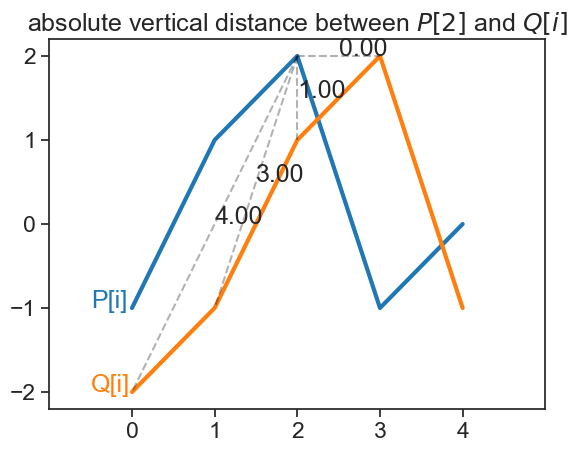

In [123]:
#| code-summary: "Plot P and Q"
plot_series(s1_b, s2_b)

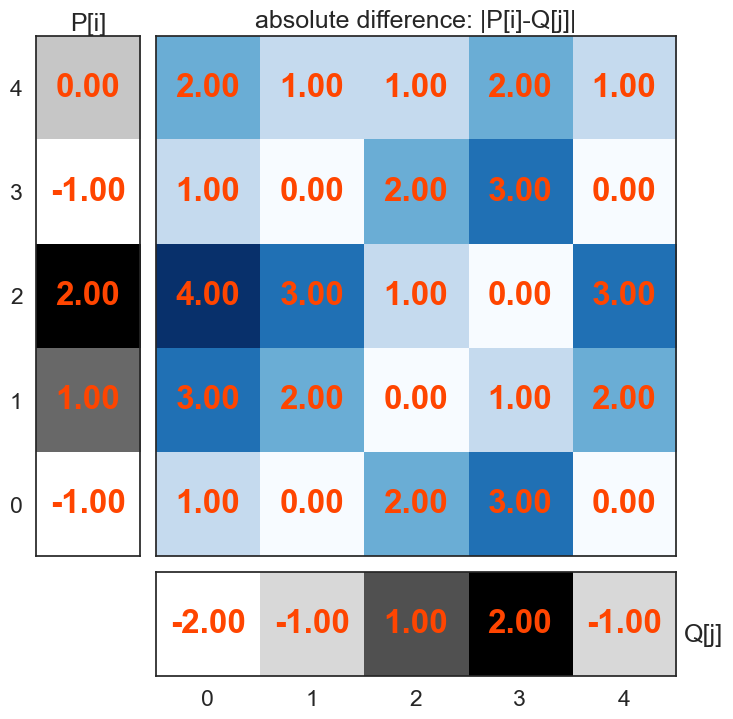

In [124]:
#| code-summary: "Let's build a matrix for the absolute differences between P and Q"
plot_abs_diff(s1_b, s2_b, c_b)

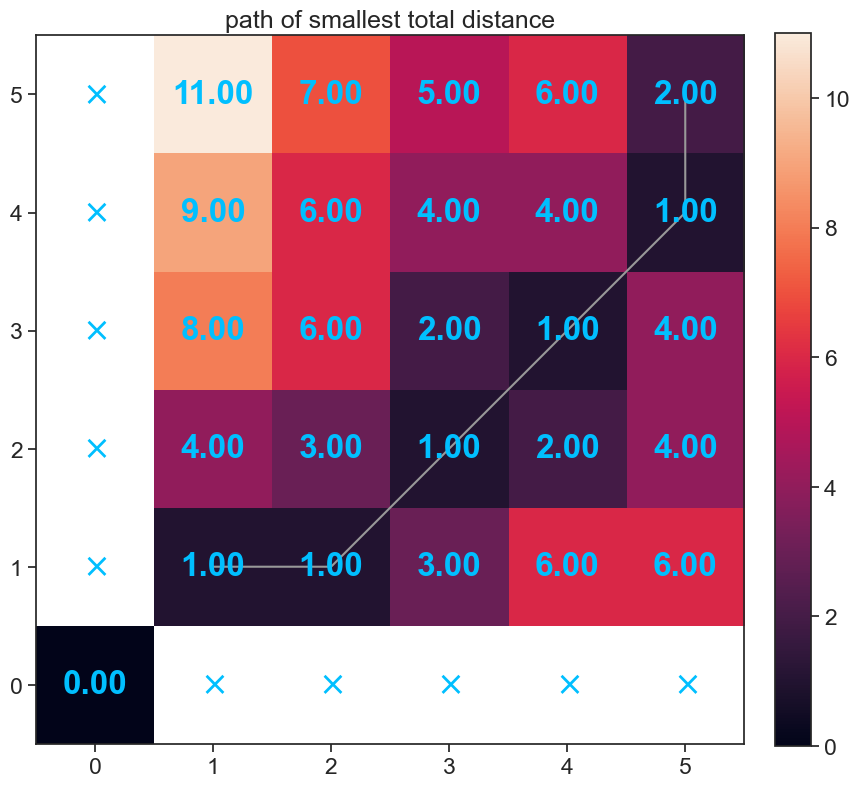

In [125]:
#| code-summary: "Let's build the cost matrix and the best path"
plot_cost_and_path(m_b, p_b)

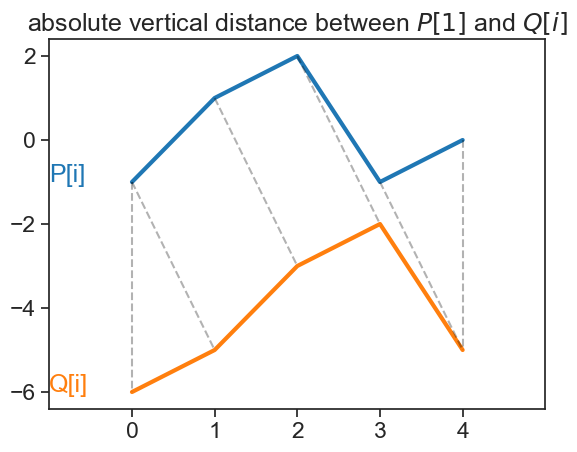

In [126]:
#| code-summary: "plot warped time series"
plot_warped_series(s1_b, s2_b, p_b)

Let's see another example.

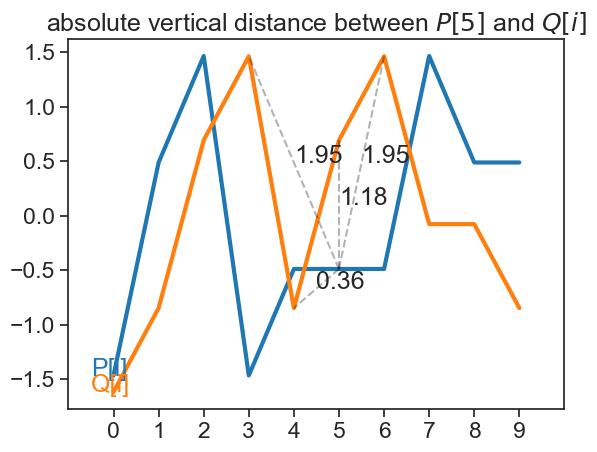

In [6]:
#| code-summary: "Plot P and Q"
plot_series(s1_c, s2_c)

These are exactly the same series from before, with additional data points.

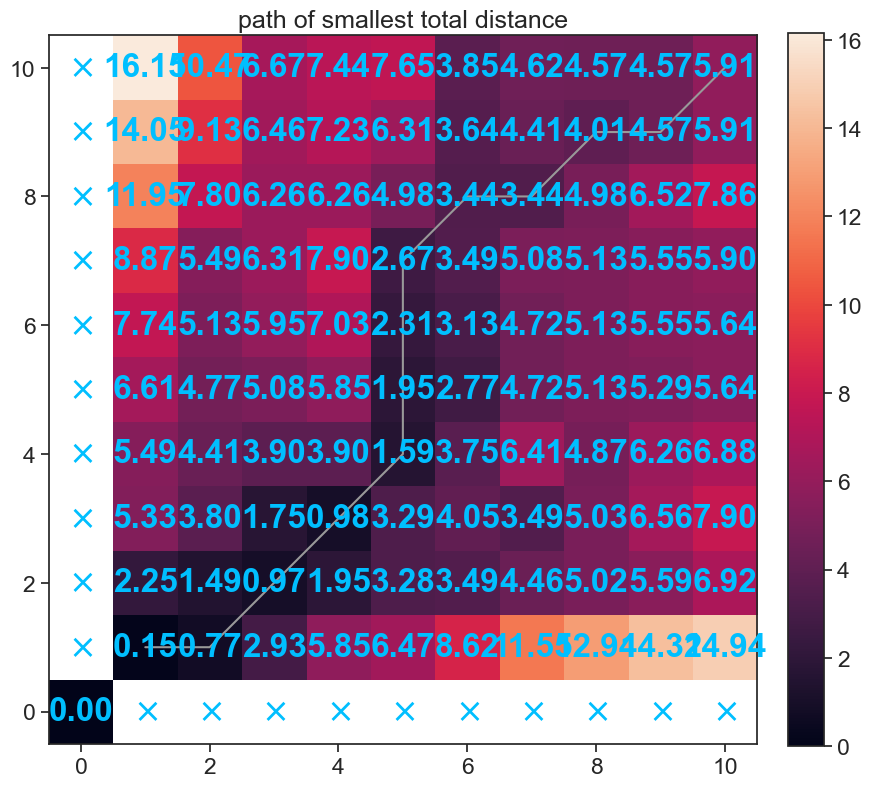

In [7]:
#| code-summary: "Let's build the cost matrix and the best path"
plot_cost_and_path(m_c, p_c)

Now the path meanders both above and below the diagonal, meaning that the second time series sometimes lags behind (bottom) and sometimes leads ahead (top) the first time series,

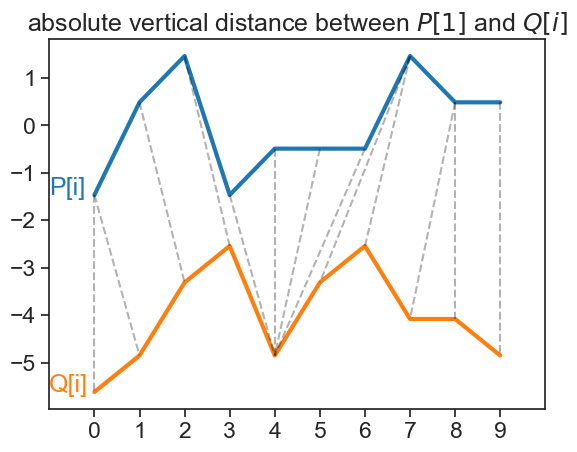

In [8]:
#| code-summary: "plot warped time series"
plot_warped_series(s1_c, s2_c, p_c)

## causality

In [11]:
s1_c = np.array([1, 3, 4, 1, 2, 2, 2, 4, 3, 3])
s2_c = np.array([-1, 0, 2, 3, 0, 2, 3, 1, 1, 0])
s1_c = normalize(s1_c)
s2_c = normalize(s2_c)
c_c = np.abs(np.subtract.outer(s1_c, s2_c))
##Call DTW function
m_c = fill_dtw_cost_matrix(c_c)

N1, N2 = m_c.shape
noncausal = np.tril_indices(n=N1,m=N2, k=-1)
m_c[noncausal] = np.nan

# p_c = np.array(find_min_path(m_c))

IndexError: index -12 is out of bounds for axis 1 with size 11

In [10]:
m_c

array([[ 0.        ,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,  0.15153451,  0.76923077,  2.92538857,  5.85077714,
         6.46847341,  8.62463121, 11.55001978, 12.93694681, 14.32387384,
        14.94157011],
       [        nan,         nan,  1.48563839,  0.97358843,  1.94717685,
         3.28128073,  3.48563839,  4.45922681,  5.02409993,  5.58897304,
         6.92307692],
       [        nan,         nan,         nan,  1.74513084,  0.97590007,
         3.28590403,  4.05282315,  3.48795004,  5.02872322,  6.56487311,
         7.898977  ],
       [        nan,         nan,         nan,         nan,  3.90128864,
         1.59359634,  3.74975414,  6.41333861,  4.87487707,  6.2618041 ,
         6.87950036],
       [        nan,         nan,         nan,         nan,         nan,
         1.95180015,  2.77385406,  4.72334256,  5.13436952,  5.28590403,
         5.644

In [ ]:
plot_abs_diff(s1_b, s2_b, c_b)

In [151]:
##Fill DTW Matrix
def fill_dtw_cost_matrix_causal(abs_diff):
    N1, N2 = abs_diff.shape
    cost_matrix = abs_diff.copy()  # make a copy
    # prepend row full of nan
    cost_matrix = np.vstack([np.full(N1, np.nan), cost_matrix])
    # prepend col full of nan
    cost_matrix = np.hstack([np.full((N2+1,1), np.nan), cost_matrix])
    # make origin zero
    cost_matrix[0, 0] = 0

    for i in range(1, N1+1):
        for j in range(1, N2+1):
            south     = cost_matrix[i-1, j  ]
            west      = cost_matrix[i  , j-1]
            southwest = cost_matrix[i-1, j-1]
            # print(([south, west, southwest]))
            # print(np.nanmin([south, west, southwest]))
            cost_matrix[i, j] = cost_matrix[i, j] + np.nanmin([south, west, southwest])
    return cost_matrix

In [152]:
##Call DTW function
m_a_causal = fill_dtw_cost_matrix_causal(c_a)
p_a_causal = np.array(find_min_path(m_a))

/var/folders/kv/9cqw3y_s6c75xmgqm9n0t5d40000gn/T/ipykernel_29281/239877799.py:21: RuntimeWarning: All-NaN axis encountered
  cost_matrix[i, j] = cost_matrix[i, j] + np.nanmin([south, west, southwest])


[Text(0.5, 1.0, 'path of smallest total distance')]

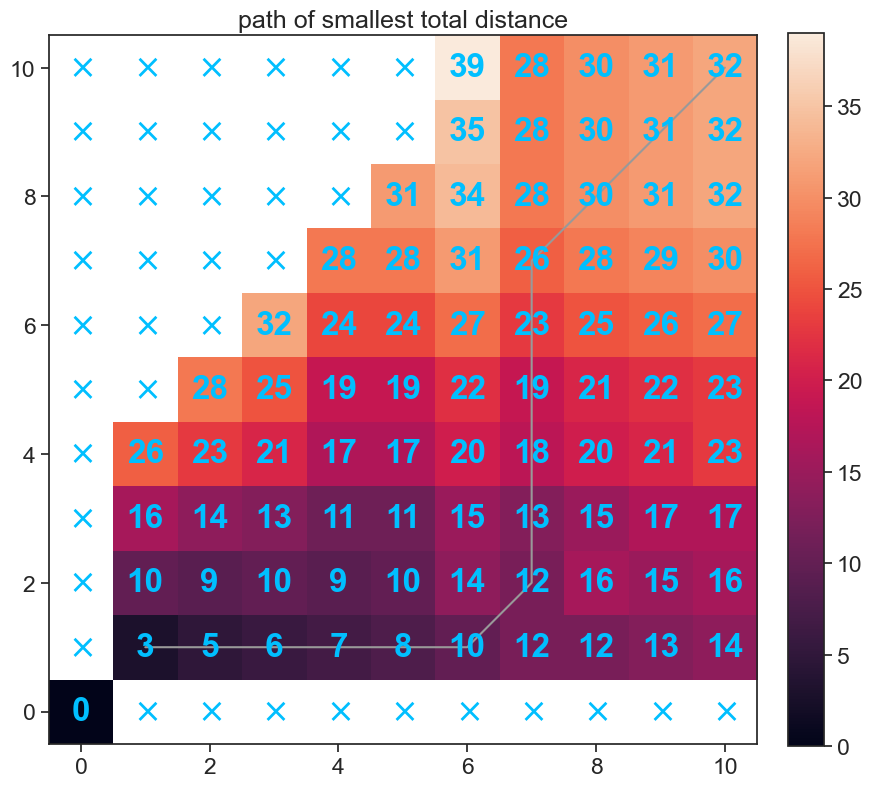

In [153]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.imshow(m_a_causal, origin="lower")
# plt.colorbar(m, ax=ax, shrink=1.0)
plt.colorbar(m,fraction=0.046, pad=0.04)

text_dict = {'ha':'center', 'va':'center', 'color':"deepskyblue",
             'fontsize':24, 'weight':'bold'}

# https://stackoverflow.com/a/33829001
for (j,i),label in np.ndenumerate(m_a_causal):
    if np.isnan(label):
        label = r"$\times$"
    else: label = f"{label:.0f}"
    ax.text(i,j,label, **text_dict, zorder=10)

ax.plot(p_a_causal[:,1], p_a_causal[:,0], color=[0.6]*3)

ax.set(title="path of smallest total distance")

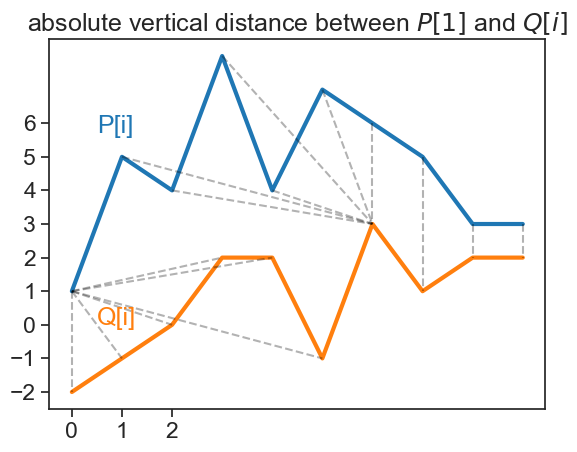

In [147]:
fig, ax = plt.subplots()

ax.plot(s1_a, color="tab:blue", lw=3)
ax.plot(s2_a, color="tab:orange", lw=3)

p1 = p_a_causal - 1

for (i,j) in p1:
    ax.plot([i, j], [s1_a[i], s2_a[j]], color="black", alpha=0.3, ls="--")

ax.text(0.5, 5.7, "P[i]", color="tab:blue")
ax.text(0.5, 0.0, "Q[i]", color="tab:orange")

ax.set(xticks=np.arange(0,3),
       yticks=np.arange(-2,7),
       title=r"absolute vertical distance between $P[1]$ and $Q[i]$");

In [139]:
a = 1.0*np.arange(16).reshape(4, 4)
# iu1 = np.triu_indices(4)
iu1 = np.tril_indices(n=4,m=5, k=-1)
a[iu1] = np.nan
a

array([[ 0.,  1.,  2.,  3.],
       [nan,  5.,  6.,  7.],
       [nan, nan, 10., 11.],
       [nan, nan, nan, 15.]])